## Imports

In [1]:
import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt
import os

from fusion import optimize
from utils import hyperspectral2RGB, hyperspectral2RGBvolume, bin_data
from utils import RESOURCES_PATH

DATA_RESOURCES_PATH = "/Users/federicosimoni/Library/Mobile Documents/com~apple~CloudDocs/Università/Tesi/Code/CS-FLIM_lab/20240703/kidney"

XY_DIM = 128
CMOS_PATH = os.path.join(DATA_RESOURCES_PATH, "kidney2_520_4m_rec_FOVcorrected.mat")
# SPC_PATH = RESOURCES_PATH / "kidney" / "520_kidneyCells_550_550_610_SPC_raw_proc_tlxy.mat"
SPC_PATH = os.path.join(DATA_RESOURCES_PATH, "520_kidney2_550_550_610_SPC_raw_proc_tlxy.mat")
LAMBDA_PATH = RESOURCES_PATH / "kidney" / "610_Lambda_L16.mat"

## Data loading

In [2]:
with h5py.File(CMOS_PATH, "r") as f:
    cmos = np.array(h5py.File(CMOS_PATH)["I"])

if cmos.ndim == 3:
    cmos = np.transpose(cmos, (1, 2, 0))
    zdim = cmos.shape[2]
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, zdim))
    cmos = np.transpose(cmos, (2, 1, 0))
else:
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM))
    cmos = np.transpose(cmos, (1, 0))
    plt.imshow(cmos)
    plt.title("Initial cmos")
    plt.show()

cmos = cmos / cmos.max()

spc = sp.io.loadmat(SPC_PATH)["im"]
t = np.squeeze(sp.io.loadmat(SPC_PATH)["t"])
spc[:, :, 0, 0] = spc[:, :, 1, 0]
# sp.io.savemat('spcOriginal.mat', {'spc': spc})
lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

# time_decay = np.sum(spc, axis=(1, 2, 3))
# plt.plot(t, time_decay)
# plt.title("Initial global time")
# plt.show()

## Time binning and initial plots

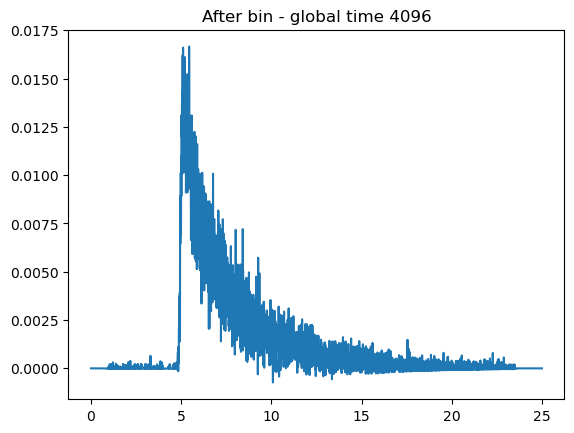

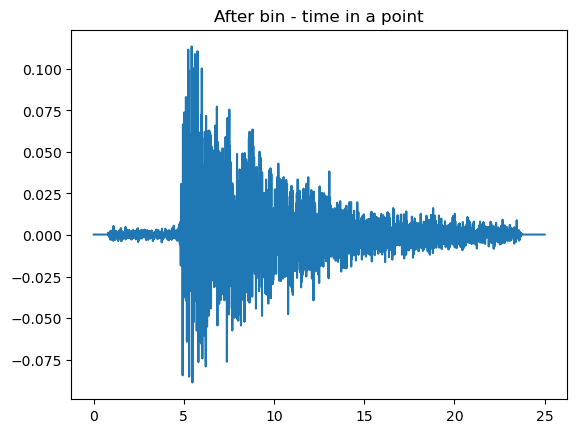

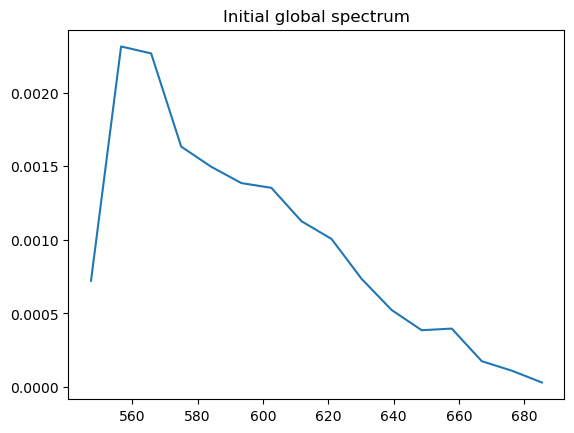

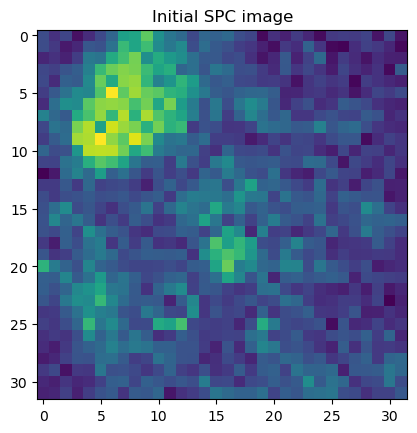

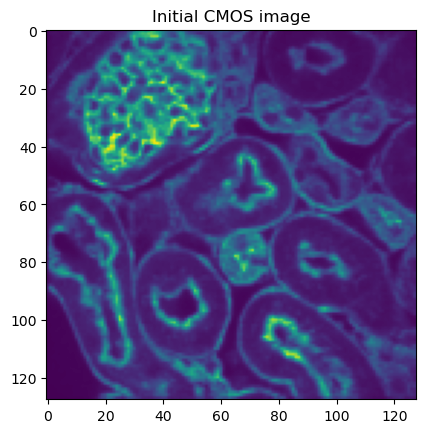

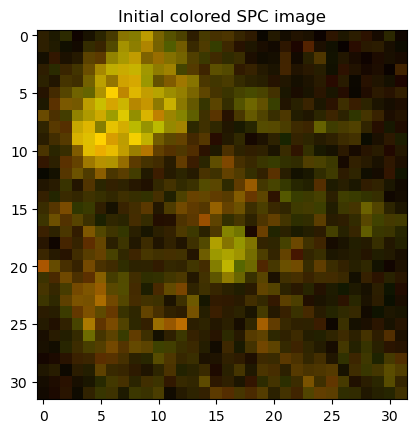

In [3]:
# # data binning
# t, spc, dt = bin_data(spc, t, 0.05)

# # cut the time
# curve = np.squeeze(np.sum(spc, axis=(1, 2, 3)))
# val = np.max(curve)
# pos_max = np.argmax(curve)
# curve = curve[pos_max:]
# b = np.argmin(abs(curve - curve[0] * (1 - np.exp(-1 / 5))))
# # curve=curve[0:b]
# spc = spc[pos_max: (pos_max + b), :, :, :]
# t = t[pos_max: (pos_max + b)]

time_decay = np.mean(spc, axis=(1, 2, 3))
plt.plot(t, time_decay)
plt.title(f"After bin - global time {len(t)}")
plt.show()

plt.plot(t, np.mean(spc[:, :, 12, 20], axis=1))
plt.title("After bin - time in a point")
plt.show()

spc = spc / np.max(spc)

plt.plot(lam, np.mean(spc, axis=(0, 2, 3)))
plt.title("Initial global spectrum")
plt.show()

plt.imshow(np.mean(spc, axis=(0, 1)))
plt.title("Initial SPC image")
plt.show()

plt.imshow(cmos[9, :, :])
plt.title("Initial CMOS image")
plt.show()

plt.imshow(hyperspectral2RGB(lam, np.mean(spc, axis=0)))
plt.title("Initial colored SPC image")
plt.show()

# plt.plot(lam,np.mean(spc[:,:,10,11],axis=0))
# plt.plot(lam,np.mean(spc[:,:,16,19],axis=0))
# plt.title('Initial spectrum specific point')
# plt.show()

# plt.plot(spc[:,12,20])
# plt.title('Initial spectrum small bead')
# plt.show()
# ==================================

# for i in range(len(spc)):
#     spc[i] = spc[i]/spc[i].max()
# mask = ski.transform.resize(np.all(mask, axis=0), (32, 32))
# spc[:, mask] = 0


## Fusion through optimization

In [4]:
spc = np.mean(spc,0,keepdims=True)

# spc = spc / np.max(spc,1)

x = optimize(spc=spc, cmos=cmos, iterations=200, weights=(1,5,1,0)) #spectral, spatial, non_neg, global_map
x = x.cpu().detach().numpy()

Iteration 1 | Spatial: 0.0723 | Non Neg: 0.0000 | Spectral cosine: 0.0396 | 
Iteration 2 | Spatial: 0.0743 | Non Neg: 0.0001 | Spectral cosine: 0.7035 | 
Iteration 3 | Spatial: 0.0733 | Non Neg: 0.0001 | Spectral cosine: 0.5662 | 
Iteration 4 | Spatial: 0.0718 | Non Neg: 0.0002 | Spectral cosine: 0.4792 | 
Iteration 5 | Spatial: 0.0701 | Non Neg: 0.0002 | Spectral cosine: 0.4189 | 
Iteration 6 | Spatial: 0.0684 | Non Neg: 0.0003 | Spectral cosine: 0.3742 | 
Iteration 7 | Spatial: 0.0667 | Non Neg: 0.0003 | Spectral cosine: 0.3394 | 
Iteration 8 | Spatial: 0.0652 | Non Neg: 0.0004 | Spectral cosine: 0.3113 | 
Iteration 9 | Spatial: 0.0638 | Non Neg: 0.0004 | Spectral cosine: 0.2880 | 
Iteration 10 | Spatial: 0.0624 | Non Neg: 0.0004 | Spectral cosine: 0.2682 | 
Iteration 11 | Spatial: 0.0612 | Non Neg: 0.0005 | Spectral cosine: 0.2511 | 
Iteration 12 | Spatial: 0.0600 | Non Neg: 0.0005 | Spectral cosine: 0.2362 | 
Iteration 13 | Spatial: 0.0589 | Non Neg: 0.0005 | Spectral cosine: 0.222

## Visualize results

In [5]:
from ipywidgets import interact

[547.35972343 556.56210764 565.76449186 574.96687608 584.1692603
 593.37164452 602.57402874 611.77641296 620.97879718 630.18118139
 639.38356561 648.58594983 657.78833405 666.99071827 676.19310249
 685.39548671]


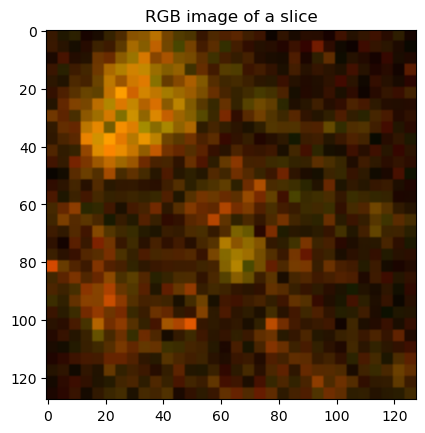

(26, 1)


interactive(children=(IntSlider(value=9, description='index_z', max=26), Output()), _dom_classes=('widget-inte…

In [6]:
# x = x / np.max(x,1)

print(lam)

zxy = np.sum(x, axis=(0, 1))
zxy /= zxy.max()

slices_rgb = hyperspectral2RGBvolume(lam, np.mean(x, axis=0))
slice_rgb = hyperspectral2RGB(lam, np.mean(x, axis=0)[:,9,:,:])

plt.imshow(slice_rgb)
plt.title("RGB image of a slice")
plt.show()

means_spectrums = np.mean(x, axis=(0, 3, 4)).T
min_mean_spectrum = np.min(means_spectrums)
max_mean_spectrum = np.max(means_spectrums)

means_times = np.mean(x, axis=(1, 3, 4)).T
print(means_times.shape)
min_mean_times = np.min(means_times)
max_mean_times = np.max(means_times)

def plot_across_z(index_z=9):
    _, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax[0, 0].imshow(zxy[index_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].set_title(f"Fused Image, z={index_z}")

    ax[0, 1].imshow(slices_rgb[index_z])
    ax[0, 1].set_title(f"Colored with spectrum")

    ax[1, 0].plot(lam, means_spectrums[index_z])
    ax[1, 0].set_ylim(min_mean_spectrum, max_mean_spectrum)
    ax[1, 0].set_title(f"Fused Spectrum, z={index_z}")

    # ax[1, 1].plot(t, means_times[index_z])
    # ax[1, 1].set_ylim(min_mean_times, max_mean_times)
    # ax[1, 1].set_title(f"Fused Time, z={index_z}")

    plt.tight_layout()
    plt.show()


interact(plot_across_z, index_z=(0, len(zxy), 1));

In [7]:
reconstructed_spectrums = np.mean(x, axis=(0, 2))
reconstructed_times = np.mean(x, axis=(1, 2))

def spectrum_time_in_a_point(i=0, j=0):
    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    z_index = np.argmax(means_spectrums.sum(axis=1))
    ax[0].imshow(slices_rgb[z_index])
    ax[0].scatter([j], [i], c="b")
    ax[0].set_title(f"Colored with spectrum")
    
    ax[1].plot(lam, reconstructed_spectrums[:, i, j])
    ax[1].set_title(f"Spectrum in ({i},{j})")
    
    # ax[2].plot(t, reconstructed_times[:, i, j])
    # ax[2].set_title(f"Time in ({i},{j})")
    # plt.tight_layout()
    # plt.show()
    
interact(spectrum_time_in_a_point, i=(0, x.shape[-2], 1), j=(0, x.shape[-1], 1));

interactive(children=(IntSlider(value=0, description='i', max=128), IntSlider(value=0, description='j', max=12…

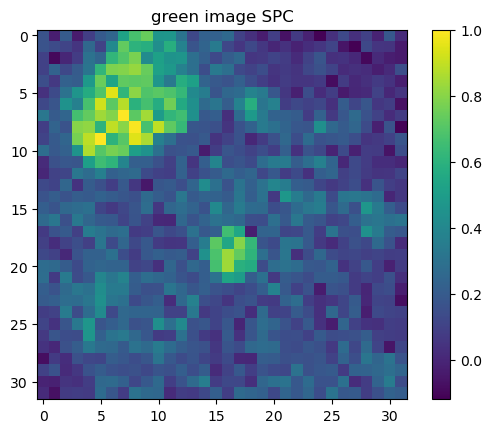

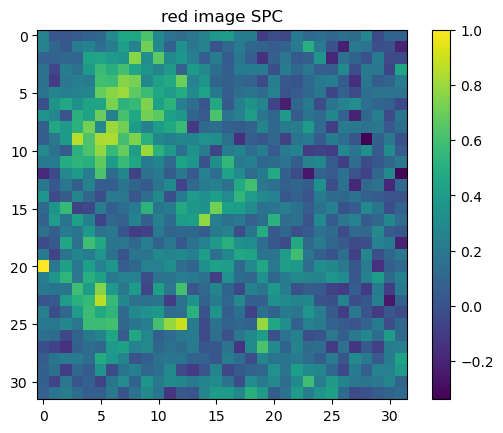

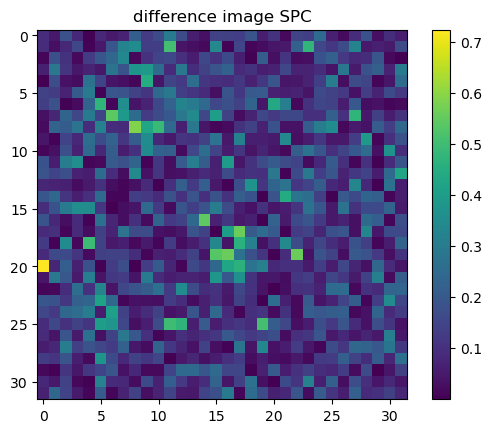

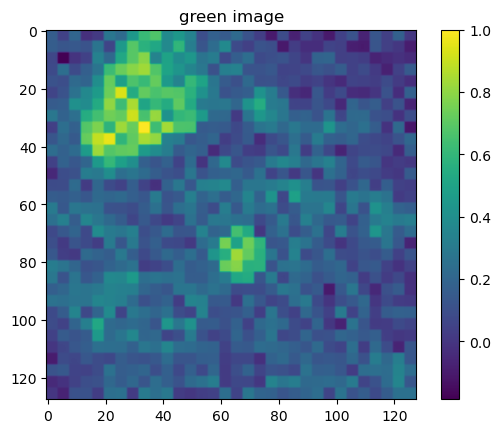

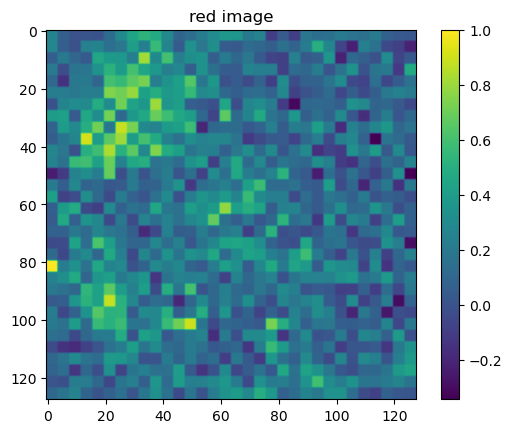

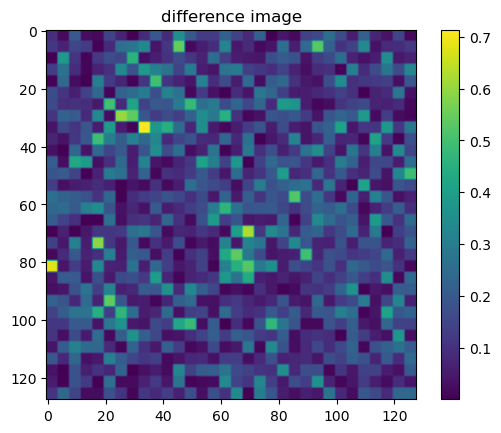

In [8]:
spc = np.squeeze(spc)
image_green_SPC = np.sum(spc[0:3,:,:],0)
image_red_SPC = np.sum(spc[8:,:,:],0)
image_green_SPC /= np.max(image_green_SPC)
image_red_SPC /= np.max(image_red_SPC)

plt.imshow(image_green_SPC)
plt.title("green image SPC")
plt.colorbar()
plt.show()

plt.imshow(image_red_SPC)
plt.title("red image SPC")
plt.colorbar()
plt.show()

plt.imshow(np.abs(image_red_SPC-image_green_SPC))
plt.title("difference image SPC")
plt.colorbar()
plt.show()

lam_image = np.squeeze(x,0)
lam_image = lam_image[:,9,:,:]

image_green = np.sum(lam_image[0:3,:,:],0)
image_red = np.sum(lam_image[8:,:,:],0)

image_green /= np.max(image_green)
image_red /= np.max(image_red)

plt.imshow(image_green)
plt.title("green image")
plt.colorbar()
plt.show()

plt.imshow(image_red)
plt.title("red image")
plt.colorbar()
plt.show()

plt.imshow(np.abs(image_red-image_green))
plt.title("difference image")
plt.colorbar()
plt.show()

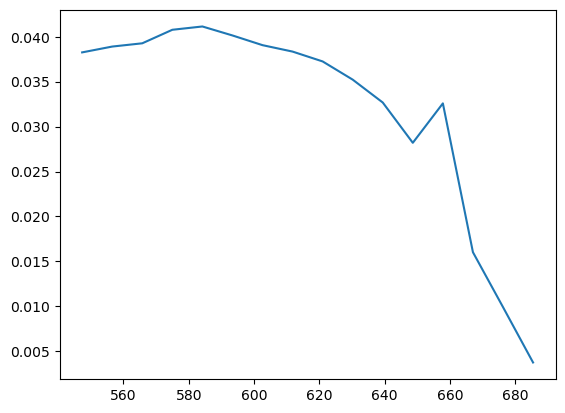

In [9]:
# plt.plot(lam, means_spectrums[9])
plt.plot(lam, means_spectrums[9])
plt.show()